# 7. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [761]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [762]:
categories = ['alt.atheism','comp.graphics',\
               'sci.space','talk.religion.misc']

In [763]:
data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)

In [764]:
data.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Выведите по 1 тексту для каждой из категории.

In [765]:
import pandas as pd

In [766]:
def to_dataframe(data):

    df = pd.DataFrame([data.data, data.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(data.target_names)
    targets.columns=['category']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    return out

In [767]:
def load_data(categories = ['alt.atheism','comp.graphics','sci.space','talk.religion.misc'],to_df=True):
    data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)    
    if to_df:
        data = to_dataframe(data)  
    return data

In [768]:
df = load_data()

In [769]:
df.head()

,text,target,category
0,My point is that you set up your views as the ...,0,alt.atheism
9,"\n]The ""corrupted over and over"" theory is pr...",0,alt.atheism
14,"\n\nBut, you wouldn't know what red *was*, and...",0,alt.atheism
26,\n\nWell I agree with you in the sense that th...,0,alt.atheism
27,"\n\nSpecifically, which changes are you talkin...",0,alt.atheism


In [770]:
for cat in df.category.unique():
    row = df[df['category']==cat].head(1)
    print('Category({}): {}\n'.format(row['target'][:1].values[0],cat))  
    print(row['text'][:1].values[0])
    print('-----------------')

Category(0): alt.atheism

My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.
-----------------
Category(1): comp.graphics


By '8 grey level images' you mean 8 items of 1bit images?
It does work(!), but it doesn't work if you have more than 1bit
in your screen and if the screen intensity is non-linear.

With 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,
this gives 16 levels, but they are linear if screen intensity

### 2.2 Мешок слов (6 баллов)

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [771]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [772]:
X = df['text']
y = df['target'].astype('int')

In [773]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [774]:
vectorizer = CountVectorizer(stop_words='english')
#X_vector = vectorizer.fit_transform(X)
X_train = vectorizer.fit_transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

In [775]:
print("Количество слов в словаре: ", len(vectorizer.vocabulary_))
X_train.shape

Количество слов в словаре:  28395


(2370, 28395)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [776]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

In [777]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [778]:
import numpy as np
import matplotlib.pyplot as plt

In [779]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_train, y_train)

CPU times: user 232 ms, sys: 51.8 ms, total: 284 ms
Wall time: 1.69 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [780]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.8101265822784809, params={'alpha': 1}


In [781]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [782]:
y_pred = clf.predict(X_test)

In [783]:
#Категории для лейблов матрицы ошибок
class_names = df.groupby(['target','category']).count().reset_index().category.values
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

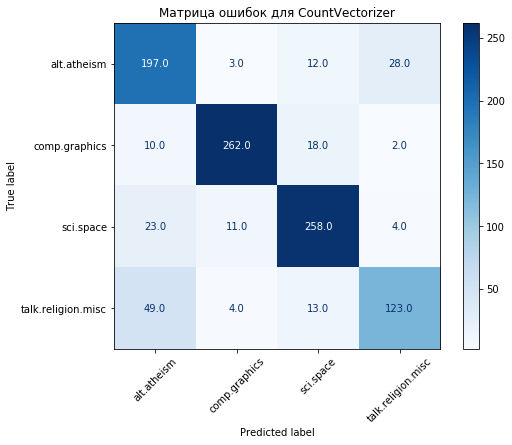

In [784]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для CountVectorizer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [785]:
print('CountVectorizer\n\n')
print(classification_report(y_test, y_pred, target_names=class_names))

CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.71      0.82      0.76       240
     comp.graphics       0.94      0.90      0.92       292
         sci.space       0.86      0.87      0.86       296
talk.religion.misc       0.78      0.65      0.71       189

          accuracy                           0.83      1017
         macro avg       0.82      0.81      0.81      1017
      weighted avg       0.83      0.83      0.83      1017



--------------- Проверка---------------

Как проверить, что лейблы выставлены правильно? Можно взять количество значений по группам в y_test, просуммировать значения в confusion_matrix по горизонтали, тем самым определив индекс метки, затем по индексу сравнить с df.  

Пример: сумма в 296 в матрице это 3 строка, лейбл указан sci.space, индекс в y_test с 296 == 2, что соответствует sci.space из df

In [786]:
y_test.value_counts()

2    296
1    292
0    240
3    189
Name: target, dtype: int64

In [787]:
df.groupby(['target','category']).count()

,,text
target,category,
0,alt.atheism,799
1,comp.graphics,973
2,sci.space,987
3,talk.religion.misc,628


--------------- Проверка завершена---------------

Добавлю сохранение предыдущего отчета, для сравнения с новым

In [788]:
def report2array(cr,rows=4):
    # classification_report to array
    tmp = list()
    m_avg=0
    num=0
    for row in cr.split("\n"):
        if 0 != num:
            parsed_row = [float(x) for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                tmp.append(parsed_row[1:4])
        num+=1
        if num > rows+1:
            break
    return np.array(tmp),m_avg

In [789]:
def report2array(cr,rows=4):
    # classification_report to array
    tmp = list()
    m_avg=0
    r_num=0
    for row in cr.split("\n"):
        if (0 != r_num) and (r_num <= rows+1): #от 2 до 5 строки
            parsed_row = [float(x) for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                tmp.append(parsed_row[1:4])
        if r_num == rows+1+3: # 8 строка macro avg
            parsed_row = [x for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                m_avg =  parsed_row[3]
                break
        r_num+=1
    return np.array(tmp), float(m_avg)

In [790]:
np.set_printoptions(precision=2)
#Сохраню текущие значения матрицы ошибок
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

In [791]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

In [792]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [jesus believe atheism say does think just don people god]
comp.graphics: [available program ftp jpeg images data file edu graphics image]
sci.space: [just data earth time orbit shuttle like launch nasa space]
talk.religion.misc: [lord know bible just don say jehovah jesus people god]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (6 баллов) 

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [793]:
from sklearn.feature_extraction.text import TfidfTransformer

In [794]:
tfidf_transformer = TfidfTransformer()

https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest  
https://stats.stackexchange.com/questions/344571/imputing-the-mean-value-from-the-train-set-into-the-test-set

In [795]:
X_tfidf_train = tfidf_transformer.fit_transform(X_train)
X_tfidf_test = tfidf_transformer.transform(X_test)

In [796]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_tfidf_train, y_train)

CPU times: user 174 ms, sys: 4.2 ms, total: 179 ms
Wall time: 330 ms


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [797]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7616033755274261, params={'alpha': 1}


In [798]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train, y_train)

y_pred_tfidf = clf.predict(X_tfidf_test)

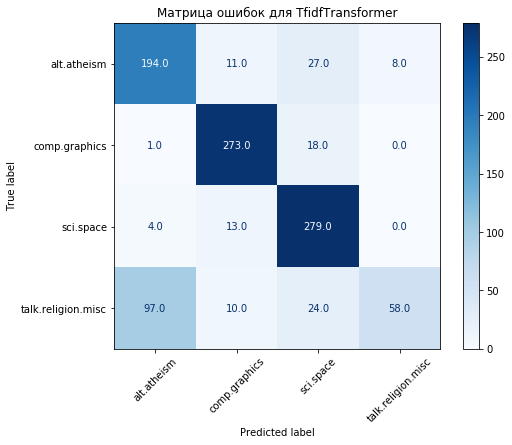

In [799]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_tfidf_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для TfidfTransformer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [800]:
print('CountVectorizer + tfidf\n\n')
cur_rep = classification_report(y_test, y_pred_tfidf, target_names=class_names)
print(cur_rep)

CountVectorizer + tfidf


                    precision    recall  f1-score   support

       alt.atheism       0.66      0.81      0.72       240
     comp.graphics       0.89      0.93      0.91       292
         sci.space       0.80      0.94      0.87       296
talk.religion.misc       0.88      0.31      0.45       189

          accuracy                           0.79      1017
         macro avg       0.81      0.75      0.74      1017
      weighted avg       0.81      0.79      0.77      1017



In [801]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred_tfidf))

In [802]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.07

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.05 -0.01 -0.04]
 [-0.05  0.03 -0.01]
 [-0.06  0.07  0.01]
 [ 0.1  -0.34 -0.26]]


Качество ухудшилось

In [803]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [believe does atheism say religion just think people don god]
comp.graphics: [need looking format program know files file image thanks graphics]
sci.space: [think don just moon launch orbit shuttle like nasa space]
talk.religion.misc: [koresh know say bible just christian don people jesus god]


In [804]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred_tfidf))

### 2.4 В чём проблема? (7 баллов)

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

![](https://i.imgur.com/3D5pgrk.png)

Ответ: Основные "проблемы" с реглигией, во первых атеизм входит в понятие религии, во вторых почему то при определении космоса и графики часть путается с религией, при этом религия не путается с космосом и графикой. Это вероятно говорит о том, что в категории религии специфичные слова имеют бОльший вес, точнее описывают категорию, в отличии от космоса, где проскальзывают слова из религии с весом далеко не на дне. Показательно TN для религии и атеизма, вероятно всего это связано с общими/одинаковыми словами в этих темах, поэтому классификатору сложно их различать. В целом у темы космоса и графики хорошие показатели полноты, точность немного страдает, но если "разобраться" с религией, то думаю станет лучше. Конечно со словарем никак не работали, нужно убирать мусорные и общие слова во всех темах,  а так же проводить анализ словарей по категорям, особенно смотреть на топовые слова. Например из космоса можно убрать слова (think just like) и прочие подобные слова убрать вообще из всех категорий. Из атеизма можно убрать (god, religion), оставив только для религии.

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.

### Дополнительная работа

##### "Мусорные" слова

Посмотрим в целом на словарь. Много цифр, а так же есть слова с "_" вместо пробела.

In [805]:
vectorizer.get_feature_names()

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000062david42',
 '0001',
 '00041032',
 '0004136',
 '00041555',
 '0004244402',
 '0004246',
 '00043819',
 '0004422',
 '00044513',
 '00044808',
 '00044939',
 '0004847546',
 '0004988',
 '0005',
 '0005169',
 '0007',
 '0008512',
 '00090711',
 '000usd',
 '0011265',
 '0012',
 '0018',
 '00196',
 '0020',
 '0022',
 '0028',
 '0029',
 '003',
 '0033',
 '0034',
 '0038',
 '0049',
 '006',
 '0065',
 '0094',
 '0098',
 '00index',
 '00pm',
 '01',
 '0100',
 '01272',
 '013846',
 '015',
 '01752',
 '01821',
 '01826',
 '0184',
 '01852',
 '01854',
 '01890',
 '0199',
 '01a',
 '01readme',
 '02',
 '020',
 '0200',
 '02115',
 '02138',
 '02139',
 '02154',
 '02178',
 '0223',
 '023220',
 '0235',
 '0238',
 '023b',
 '024',
 '0245',
 '03',
 '030',
 '0300',
 '03051',
 '031',
 '033',
 '0330',
 '034',
 '04',
 '040',
 '0410',
 '04110',
 '041493003715',
 '0418',
 '0430',
 '045',
 '0451',
 '04g',
 '05',
 '050',
 '0500',
 '0511',
 '05402',
 '05446',
 '0545',
 '054589

In [806]:
import re

Сначала разберусь с цифрами. 
 - Цифры состояшие из 4х символов заменю на #года + #века
 - Цифры по примеру 800x600.. заменю на #разрешение
 - все цифры включая шаблоны выше заменю на #цифры
 - Цифры по примеру'6am' или '18:58' заменю на #время
 - Даты заменю на #date

In [807]:
vectorizer.get_feature_names()[:500]

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000062david42',
 '0001',
 '00041032',
 '0004136',
 '00041555',
 '0004244402',
 '0004246',
 '00043819',
 '0004422',
 '00044513',
 '00044808',
 '00044939',
 '0004847546',
 '0004988',
 '0005',
 '0005169',
 '0007',
 '0008512',
 '00090711',
 '000usd',
 '0011265',
 '0012',
 '0018',
 '00196',
 '0020',
 '0022',
 '0028',
 '0029',
 '003',
 '0033',
 '0034',
 '0038',
 '0049',
 '006',
 '0065',
 '0094',
 '0098',
 '00index',
 '00pm',
 '01',
 '0100',
 '01272',
 '013846',
 '015',
 '01752',
 '01821',
 '01826',
 '0184',
 '01852',
 '01854',
 '01890',
 '0199',
 '01a',
 '01readme',
 '02',
 '020',
 '0200',
 '02115',
 '02138',
 '02139',
 '02154',
 '02178',
 '0223',
 '023220',
 '0235',
 '0238',
 '023b',
 '024',
 '0245',
 '03',
 '030',
 '0300',
 '03051',
 '031',
 '033',
 '0330',
 '034',
 '04',
 '040',
 '0410',
 '04110',
 '041493003715',
 '0418',
 '0430',
 '045',
 '0451',
 '04g',
 '05',
 '050',
 '0500',
 '0511',
 '05402',
 '05446',
 '0545',
 '054589

In [808]:
#дата
def GetDate (txt):  
    out = re.sub(r'\b[^#]\d+[:,\.]\d+[\.]\d+\b',' #numb #date',str(txt))
    return out

In [809]:
#года и века
def GetYearCentury (txt):
    def GetCentury (year):
        cen = re.findall(r'\b\d{2,2}',str(year)) #первые 2 числа
        cen = int(cen[0]) + 1
        return '#numb #year #centry{}'.format(cen)
    out =  re.sub(r'\b[1-2]{1}\d{3}\b',lambda y: GetCentury(y.group(0)),str(txt))
    return out

In [810]:
#разрешение экрана
def GetResolution (txt):  
    out = re.sub(r'[^#]\d+[x]\w+\b',' #numb #resolution',str(txt))
    return out

In [827]:
#размер файла
def GetFileSize (txt):  
    out = re.sub(r'[^#]\d+[m,M,M,b,B,k,K,K,g,G,G]{1,1}[b,B,y]{1,1}\b',' #numb #filesize',str(txt))
    return out

In [1155]:
#какой то размер
def GetSomeSize (txt):  
    out = re.sub(r'[^#]\d+[a-z]{1,3}\b',' #numb #somesize',str(txt))
    return out

In [1157]:
#!!! Почему не берет первую 2nd?
GetSomeSize('2nd 2nd 3e #numb2')

'2nd #numb #somesize #numb #somesize #numb2'

In [1145]:
#время
def GetTime (txt):  
    out = re.sub(r'[^#]\d+:\d+[\w,:]+\b',' #numb #time',str(txt))
    return out

In [1139]:
#сначала цифра, затем буквы и/или цифры
def GetNumbAndLetters (txt):  
    out = re.sub(r'[^#]\d+[a-z]+\w+\b',' #numb_lett',str(txt))
    return out

In [866]:
#любые цифры, только цифры
def GetNumbOnly (txt):  
    out = re.sub(r'[^#]\d+\b',' #numb',str(txt))
    return out

In [1111]:
#слова на латинице от 3х букв
def GetEnWords (txt):
    txt = txt.replace('_','')
    #out = re.findall(r'\b[^#][a-z]{3,}\b',str(txt.replace('_',''))) #слова на латинице от 3х букв 
    out = re.sub(r'[^#0-9]\b[a-z]{1,3}\b','',str(txt))
    return out

In [1134]:
re_check = ['00','0000','00000','0065','000005102000','0004246',
 '000062david42',
 '000usd','1000k1','101h','10km','10kw','10m','10mhz','1500kg','15rpm',
 '2e','2nd','0x0','0xc010','1024x768','1024x768x24',
 '1024','1951','1000','2011',
 '100mb','1GB','110mbytes',
 '15:25:64','6:52',
 '13.02.1999','13.02.99',
 'move','end', 'just', 'i',
 '_____________________',
 '___samuel___',
  ]
re_check = ' '.join(re_check)

In [1135]:
def re_Parse(txt,cv_parse=True,tresh=True):
    def process(txt,cv_parse=True):
        if cv_parse:
            vectorizer_tmp = CountVectorizer(stop_words='english')
            vectorizer_tmp.fit([txt])
            voc = vectorizer_tmp.get_feature_names()
            txt = ' '.join(voc)
        txt = GetDate(txt)
        txt = GetYearCentury(txt)
        txt = GetResolution(txt)
        txt = GetFileSize(txt)
        txt = GetSomeSize(txt)
        txt = GetTime(txt)
        txt = GetNumbAndLetters(txt)
        txt = GetNumbOnly(txt)
        txt = GetEnWords(txt)
        return txt
    if tresh:
        if len(txt.split(' ')) > 20: #Если слов в статье больше 20, то берем
            txt = process(txt,cv_parse)
    else:
        txt = process(txt,cv_parse)
    return txt

Сформирую новый столбец с текстом, который будет содержать только слова, затем на основе него составлю новый словарь.

In [1126]:
df['text_f3'] = df['text'].apply(lambda r: re_Parse(r))

In [1127]:
#text_f3 == nan, это статьи, у которых мало текста или вообще нет или он состоит только из стоп слов
df.isnull().sum()

text        0
target      0
category    0
text_f3     0
dtype: int64

In [1128]:
df.dropna(inplace=True)

In [1129]:
df[['text','text_f3']].head()

,text,text_f3
0,My point is that you set up your views as the ...,agaist atheism atheists attacks bacause believ...
9,"\n]The ""corrupted over and over"" theory is pr...",believe brothers changed closed comparison cop...
14,"\n\nBut, you wouldn't know what red *was*, and...",applicable certainly couldn discuss judge know...
26,\n\nWell I agree with you in the sense that th...,adam agree avoid behaviour best criminal delet...
27,"\n\nSpecifically, which changes are you talkin...",#numb arguing changes interpreted larger mott...


In [1130]:
X = df['text_f3']
y = df['target'].astype('int')

In [1131]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.7, stratify=y)

In [1132]:
vectorizer_f3 = CountVectorizer(stop_words='english')
X_train_f3 = vectorizer_f3.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3.transform(X_test_orig)

In [1133]:
vectorizer_f3.get_feature_names()

['0e',
 '0m',
 '0x',
 '1b',
 '1king',
 '2c',
 '2d',
 '2e',
 '2nd',
 '3d',
 '3do',
 '3ds',
 '3he',
 '3rd',
 '3rds',
 '6billion',
 '7th',
 '8bit',
 '9b',
 '9qr',
 'aacs',
 'aarnet',
 'abandon',
 'abandoned',
 'abandoning',
 'abbreviation',
 'abc',
 'abdullah',
 'aberdeen',
 'aberration',
 'abhorrent',
 'abide',
 'abiding',
 'abilities',
 'ability',
 'abiogenesis',
 'ablaze',
 'able',
 'ablutions',
 'aboard',
 'abolition',
 'abolitionists',
 'abominable',
 'abomination',
 'abominations',
 'abort',
 'aborted',
 'abortion',
 'abortions',
 'abounded',
 'aboutthisissue',
 'abraham',
 'abrams',
 'abravanel',
 'abruptly',
 'absence',
 'absolute',
 'absolutely',
 'absolutes',
 'absolutist',
 'absorbs',
 'absorption',
 'abstact',
 'abstacted',
 'abstinence',
 'abstract',
 'abstracts',
 'abstruse',
 'absurd',
 'absurdities',
 'absurdly',
 'abundantly',
 'abuse',
 'abused',
 'abuser',
 'abutaha',
 'abyss',
 'aca',
 'academic',
 'acadmic',
 'acceleration',
 'accelerations',
 'accelerator',
 'accept'

In [1158]:
print('Слов в словаре до очистке от мусора: {}'.format(len(vectorizer.get_feature_names())))
print('Слов в словаре после очистке от мусора: {}'.format(len(vectorizer_f3.get_feature_names())))

Слов в словаре до очистке от мусора: 28395
Слов в словаре после очистке от мусора: 14914


In [1159]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7880359048396209, params={'alpha': 1}


In [1160]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1161]:
y_pred = clf.predict(X_test_f3)

In [1164]:
print('Очистка мусорных слов + CountVectorizer\n\n')
cur_rep = classification_report(y_test, y_pred, target_names=class_names)
print(cur_rep)

Очистка мусорных слов + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.63      0.85      0.73       491
     comp.graphics       0.88      0.96      0.91       600
         sci.space       0.91      0.84      0.87       618
talk.religion.misc       0.74      0.38      0.50       374

          accuracy                           0.79      2083
         macro avg       0.79      0.76      0.75      2083
      weighted avg       0.80      0.79      0.78      2083



In [1166]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [1167]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: 0.01

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.03  0.04  0.01]
 [-0.01  0.03  0.  ]
 [ 0.11 -0.1   0.  ]
 [-0.14  0.07  0.05]]


In [1168]:
show_top10(clf, vectorizer_f3, class_names)

alt.atheism: [time make year like know does think people just numb]
comp.graphics: [does thanks resolution know graphics like centr year somesize numb]
sci.space: [think time know just somesize like space centr year numb]
talk.religion.misc: [point good jesus just know does think believe people numb]


In [436]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

!!! взять котегорию, сделать словарь, словарь почистить и сохранить. далее точно так же вторую категорию и т.д. Затем полученные очищенные словари объединить в мешок слов и уже по нему фитить коунтвекторайзер и трансформировать необработанный текст

In [1169]:
X_tfidf_train_f3 = tfidf_transformer.fit_transform(X_train_f3)
#X_tfidf_test = tfidf_transformer.fit_transform(X_test)
X_tfidf_test_f3 = tfidf_transformer.transform(X_test_f3)

In [1170]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_tfidf_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7297909735735358, params={'alpha': 1}


In [1171]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [1172]:
y_pred_tfidf = clf.predict(X_tfidf_test_f3)

In [1173]:
cur_rep = classification_report(y_test, y_pred_tfidf , target_names=class_names)
print('Очистка мусорных слов + CountVectorizer + tfidf\n\n')
print(cur_rep)

Очистка мусорных слов + CountVectorizer + tfidf


                    precision    recall  f1-score   support

       alt.atheism       0.62      0.81      0.70       491
     comp.graphics       0.84      0.97      0.90       600
         sci.space       0.78      0.90      0.84       618
talk.religion.misc       0.90      0.09      0.17       374

          accuracy                           0.76      2083
         macro avg       0.79      0.69      0.65      2083
      weighted avg       0.78      0.76      0.71      2083



In [1174]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred_tfidf))

In [1175]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.09

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.04  0.   -0.02]
 [-0.05  0.04 -0.01]
 [-0.02 -0.04 -0.03]
 [ 0.02 -0.22 -0.28]]


In [412]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

### Top и Tail слова

Посмотрим на Top и Tail слова общего словаря

In [1176]:
#Слова и их веса
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

In [1178]:
#объединение слов и весов
rr = dict(zip(vectorizer_f3.get_feature_names(), tfidf_transformer.idf_))

In [1179]:
rr_voc = token_weight_df(rr,'word')

In [1180]:
rr_voc.head(10)

,word,weight_word
0,0e,7.101439
8355,miniatures,7.101439
8339,mimic,7.101439
8342,mindlessly,7.101439
8343,mindmush,7.101439
8344,mindnumbing,7.101439
8349,minerals,7.101439
8350,miners,7.101439
8352,mingled,7.101439
8356,miniaturized,7.101439


In [1181]:
rr_voc.tail(10)

,word,weight_word
7941,make,2.874606
14840,year,2.852944
13487,time,2.738341
9598,people,2.629801
13403,think,2.607201
3993,does,2.601630
7646,like,2.419308
7216,just,2.410092
7359,know,2.410092
8994,numb,1.894689


Уберу из словаря часто встречающиеся и редко встречающиеся слова

max_df = 0.50 означает «игнорировать термины, встречающиеся в более чем 50% документов »  
max_df = 25 означает «игнорировать термины, встречающиеся в более чем 25 документах »  
  

min_df = 0.01означает «игнорировать термины, встречающиеся менее чем в 1% документов »  
min_df = 5означает «игнорировать термины, встречающиеся менее чем в 5 документах »  

In [437]:
cv_max_df=0.2 #Параметры для CountVectorizer default 1.0
cv_min_df=0.01 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)

In [438]:
vectorizer_f3 = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english')

In [439]:
X_train_f3 = vectorizer_f3.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3.transform(X_test_orig)

In [440]:
X_tfidf_train_f3 = tfidf_transformer.fit_transform(X_train_f3)
X_tfidf_test_f3 = tfidf_transformer.transform(X_test_f3)

In [441]:
rr = dict(zip(vectorizer_f3.get_feature_names(), tfidf_transformer.idf_))
rr_voc = token_weight_df(rr,'word')

In [442]:
rr_voc.head(10)

,word,weight_word
1187,zero,5.439706
916,san,5.439706
211,claiming,5.439706
904,risk,5.439706
896,responses,5.439706
892,resources,5.439706
231,comp,5.439706
234,compared,5.439706
237,complex,5.439706
243,congress,5.439706


In [443]:
rr_voc.tail(10)

,word,weight_word
1125,ve,3.179680
1112,use,3.179680
634,make,3.153928
924,say,3.104331
1147,way,3.041810
456,good,2.954799
1075,time,2.862017
762,people,2.849439
329,does,2.824746
1069,think,2.812625


In [444]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train_f3, y_train)

BEST: score=0.7352361634308896, params={'alpha': 1}


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [445]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [446]:
y_pred = clf.predict(X_tfidf_test_f3)

In [447]:
print('Очистка мусорных слов + CountVectorizer + tfidf + max_df/min_df \n\n')
print(classification_report(y_test, y_pred, target_names=class_names))

Очистка мусорных слов + CountVectorizer + tfidf + max_df/min_df 


                    precision    recall  f1-score   support

       alt.atheism       0.64      0.70      0.67       559
     comp.graphics       0.84      0.89      0.87       681
         sci.space       0.74      0.84      0.79       691
talk.religion.misc       0.71      0.42      0.53       440

          accuracy                           0.74      2371
         macro avg       0.73      0.71      0.71      2371
      weighted avg       0.74      0.74      0.73      2371



In [448]:
print('Разница в показателях с предыдущим отчетом:\nprecision / recall / f1-score ')
report2array(classification_report(y_test, y_pred)) - cr_old

Разница в показателях с предыдущим отчетом:
precision / recall / f1-score 


array([[ 0.02,  0.08,  0.05],
       [-0.02,  0.04,  0.01],
       [-0.05,  0.03, -0.01],
       [ 0.15, -0.13, -0.02]])

In [324]:
cr_old = report2array(classification_report(y_test, y_pred))

Как только я убрал часто встречающиеся слова, точно категории "религия" резко возрасла. Видио это говорит о том, что в этой категории слишком много слов похожих на другие категории

### Отдельные словари для каждой категории

Попробую понять чем космос пересекается с религией и убрать эти слова из какой-то категории  
Сделаю отдельные словари на каждую категорию, затем попробую их почистить и затем объединить все в один словарь

In [325]:
#Возьму только космос
X = df[df.target == 2]['text_f3']
y = df[df.target == 2]['target']

In [326]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.7)

In [327]:
cv_max_df=.05 #Параметры для CountVectorizer default 1.0
cv_min_df= 3 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)

vectorizer_space = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english')

X_train_space = vectorizer_space.fit_transform(X_train_orig)
X_test_space = vectorizer_space.transform(X_test_orig)

X_tfidf_train_space = tfidf_transformer.fit_transform(X_train_space)
X_tfidf_test_space = tfidf_transformer.transform(X_test_space)

In [328]:
rr = dict(zip(vectorizer_space.get_feature_names(), tfidf_transformer.idf_))
rr_voc = token_weight_df(rr,'word')

In [329]:
rr_voc.head(10)

,word,weight_word
0,ability,5.307438
724,limit,5.307438
746,luck,5.307438
748,machines,5.307438
755,maintaining,5.307438
760,managed,5.307438
762,manager,5.307438
763,maneuvering,5.307438
764,manifest,5.307438
766,mantle,5.307438


In [330]:
rr_voc.tail(10)

,word,weight_word
1225,software,3.985682
665,isn,3.985682
1220,sky,3.985682
587,heard,3.985682
592,help,3.985682
904,orbital,3.985682
130,big,3.985682
805,million,3.985682
413,end,3.985682
859,night,3.985682


In [451]:
#SVD разложение до 1000 фичей
#+визуализация